In [1]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/final_bigram_counts.p','rb')
final_bigram_counts=pickle.load(filename)
filename.close()

In [4]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/text_tf_idf.p','rb')
text_tf_idf=pickle.load(filename)
filename.close()

In [5]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/amazon_data.p','rb')
amazon_data=pickle.load(filename)
filename.close()

In [6]:
amazon_data.head()

,Score,Time,Text
138706,1,939340800,everi book educ witti littl book make son laug...
138683,1,940809600,whole seri great way spend time child rememb s...
417839,1,944092800,entertainingl funni beetlejuic well written mo...
417859,1,944438400,modern day fairi tale twist rumplestiskin capt...
417838,1,946857600,fantast beetlejuic excel funni movi keaton hil...


# Training on BOW Features

## Time Based Splitting

In [13]:
#taking first 70% data_points as training data and rest as test_data
X_train_bow = final_bigram_counts[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_bow = final_bigram_counts[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [14]:
#importing required libraries 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np
from tqdm.auto import tqdm


In [ ]:
estimators = [100,300,500,1000]

#finding the optimal alpha value

cv_scores_xgb= []


# perform 5-fold cross validation
for a in tqdm(estimators):
  XGB_BOW = XGBClassifier(n_estimators=a)
  scores_BOW = cross_val_score(XGB_BOW, X_train_bow, y_train, cv=3, scoring='accuracy')
  cv_scores_xgb.append(scores_BOW.mean())
    
    

In [43]:
cv_scores_xgb

[0.8981009654046971, 0.9217712292924419, 0.929248114106834, 0.937042746911764]

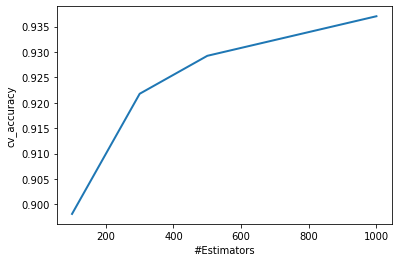

the optimal value for #Estimators is 1000:


In [45]:
#plot between cv_scores and alpha values
plt.plot(estimators ,  cv_scores_xgb,linewidth = 2.0 , linestyle="-")

plt.ylabel("cv_accuracy")
plt.xlabel("#Estimators")
plt.show()    
    
#getting the optimal_aplha-value
optimal_est_bow = estimators[cv_scores_xgb.index(max(cv_scores_xgb))]
print("the optimal value for #Estimators is {}:".format(optimal_est_bow))

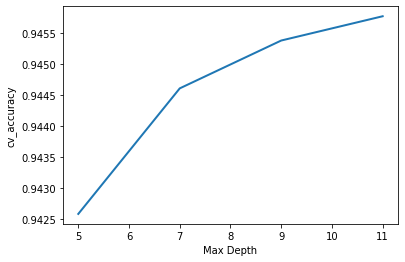

the optimal value for max_depth is 300:


In [47]:
Depths = [5,7,9,11]

cv_scores_xgb= []


# perform 5-fold cross validation
for depth in tqdm(Depths):
  XGB_BOW = XGBClassifier(n_estimators=optimal_est_bow,max_depth=depth)
  scores_BOW = cross_val_score(XGB_BOW, X_train_bow, y_train, cv=3, scoring='accuracy')
  cv_scores_xgb.append(scores_BOW.mean())
    
    
    
#plot between cv_scores and alpha values
plt.plot(Depths ,  cv_scores_xgb,linewidth = 2.0 , linestyle="-")
plt.ylabel("cv_accuracy")
plt.xlabel('Max Depth')
plt.show()    
    
#getting the optimal_aplha-value
optimal_depth_bow = Depths[cv_scores_bow.index(max(cv_scores_bow))]
print("the optimal value for max_depth is {}:".format(optimal_depth_bow))

# Predict on test data with best hyper-parameters

In [48]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
XGB_bow = XGBClassifier(n_estimators=optimal_est_bow,max_depth=optimal_depth_bow)

#fitting the NB model
XGB_bow.fit(X_train_bow,y_train)

#predicting for test_data 
XGB_pred_bow = XGB_bow.predict(X_test_bow)

XGB_pred_train_bow = XGB_bow.predict(X_train_bow)


#computing accuracy on test_data 
acc_XGB_bow = accuracy_score(y_test,XGB_pred_bow)*100
test_error_bow = (100-acc_XGB_bow)
train_error_bow =( 1-accuracy_score(y_train,XGB_pred_train_bow))*100
                  
                  
print("test accuracy using XGB : {0:.2f}%" .format(round(acc_XGB_bow,2)))
print("test error using XGB : {0:.2f}%" .format(round(test_error_bow,2)))
print("train error using XGB : {0:.2f}%" .format(round(train_error_bow,2)))

test accuracy using XGB : 94.18%
test error using XGB : 5.82%
train error using XGB : 0.00%


In [49]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_bow = precision_score(y_test,XGB_pred_bow)*100
recall_bow = recall_score(y_test,XGB_pred_bow)*100
f1_bow = f1_score(y_test,XGB_pred_bow)*100



def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN, FN, FP, TP = confusion_matrix_values(y_test,XGB_pred_bow)


print("precision score using XGB classifier is : {0:.2f}%".format(round(precision_bow,2)))

print("Recall score using XGB classifier is : {0:.2f}%" .format(round(recall_bow,2)))

print("F1-score using XGB classifier is : {0:.2f}%".format(round(f1_bow,2)))

print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))


precision score using XGB classifier is : 94.97%
Recall score using XGB classifier is : 98.15%
F1-score using XGB classifier is : 96.53%
True positive = 88507
False positive = 1668
False negative = 4686
True negative = 14391


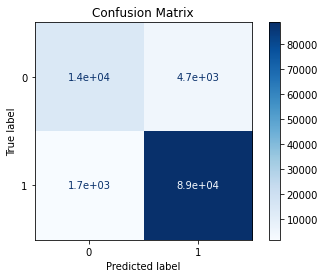

In [50]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_bow, X_test_bow, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

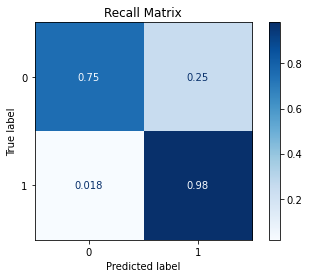

In [51]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

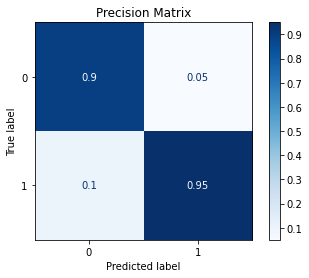

In [52]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='pred') 
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [53]:
#reporting the results in a table
from prettytable import PrettyTable

t= PrettyTable()

t.field_names =["metric/Parameter" , "result"]

t.add_row (["Model" ,"Classification"])
t.add_row (["Classifier" ,"XGB"])
t.add_row  (["Optimal_estimators" , optimal_est_bow])
t.add_row  (["Optimal_depth" , optimal_depth_bow])
t.add_row(["test accuracy" ,round(acc_XGB_bow,2)])
t.add_row (["Train_error" ,round(train_error_bow,2)])
t.add_row (["Test error" , round(test_error_bow,2)])

In [54]:
print(t)

+--------------------+----------------+
|  metric/Parameter  |     result     |
+--------------------+----------------+
|       Model        | Classification |
|     Classifier     |      XGB       |
| Optimal_estimators |      1000      |
|   Optimal_depth    |      300       |
|   test accuracy    |     94.18      |
|    Train_error     |      0.0       |
|     Test error     |      5.82      |
+--------------------+----------------+


# Training on TFIDF Features

## Time Based Splitting

In [7]:
#taking first 70% data_points as training data and rest as test_data
X_train_tfidf = text_tf_idf[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_tfidf = text_tf_idf[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [10]:
#importing required libraries 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np
from tqdm.auto import tqdm


In [9]:
estimators = [100,300,500,1000]

#finding the optimal alpha value

cv_scores_xgb= []


# perform 5-fold cross validation
for a in tqdm(estimators):
  XGB_tfidf = XGBClassifier(n_estimators=a)
  scores_tfidf = cross_val_score(XGB_tfidf, X_train_tfidf, y_train, cv=3, scoring='accuracy')
  cv_scores_xgb.append(scores_tfidf.mean())
    
    

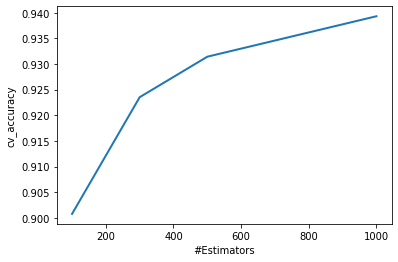

the optimal value for #Estimators is : 1000


In [11]:
#plot between cv_scores and alpha values
plt.plot(estimators ,  cv_scores_xgb,linewidth = 2.0 , linestyle="-")

plt.ylabel("cv_accuracy")
plt.xlabel("#Estimators")
plt.show()    
    
#getting the optimal_aplha-value
optimal_est_tfidf = estimators[cv_scores_xgb.index(max(cv_scores_xgb))]
print("the optimal value for #Estimators is : {}".format(optimal_est_tfidf))

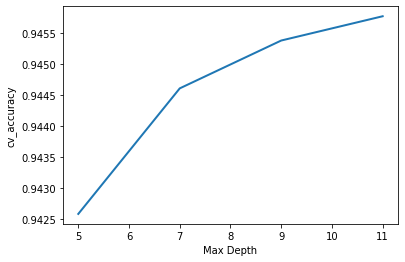

the optimal value for max_depth is 300:


In [ ]:
Depths = [5,7,9,11]

cv_scores_xgb= []


# perform 5-fold cross validation
for depth in tqdm(Depths):
  XGB_tfidf = XGBClassifier(n_estimators=optimal_est_tfidf,max_depth=depth)
  scores_tfidf = cross_val_score(XGB_tfidf, X_train_tfidf, y_train, cv=3, scoring='accuracy')
  cv_scores_xgb.append(scores_tfidf.mean())
    
    
    
#plot between cv_scores and alpha values
plt.plot(Depths ,  cv_scores_xgb,linewidth = 2.0 , linestyle="-")
plt.ylabel("cv_accuracy")
plt.xlabel('Max Depth')
plt.show()    
    
#getting the optimal_aplha-value
optimal_depth_tfidf = Depths[cv_scores_tfidf.index(max(cv_scores_tfidf))]
print("the optimal value for max_depth is {}:".format(optimal_depth_tfidf))

## Predict on test data with best hyper-parameters

In [13]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
XGB_tfidf = XGBClassifier(n_estimators=optimal_est_tfidf,max_depth=optimal_depth_tfidf)

#fitting the NB model
XGB_tfidf.fit(X_train_tfidf,y_train)

#predicting for test_data 
XGB_pred_tfidf = XGB_tfidf.predict(X_test_tfidf)

XGB_pred_train_tfidf = XGB_tfidf.predict(X_train_tfidf)


#computing accuracy on test_data 
acc_XGB_tfidf = accuracy_score(y_test,XGB_pred_tfidf)*100
test_error_tfidf = (100-acc_XGB_tfidf)
train_error_tfidf =( 1-accuracy_score(y_train,XGB_pred_train_tfidf))*100
                  
                  
print("test accuracy using XGB : {0:.2f}%" .format(round(acc_XGB_tfidf,2)))
print("test error using XGB : {0:.2f}%" .format(round(test_error_tfidf,2)))
print("train error using XGB : {0:.2f}%" .format(round(train_error_tfidf,2)))

test accuracy using XGB : 94.56%
test error using XGB : 5.44%
train error using XGB : 1.08%


In [14]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_tfidf = precision_score(y_test,XGB_pred_tfidf)*100
recall_tfidf = recall_score(y_test,XGB_pred_tfidf)*100
f1_tfidf = f1_score(y_test,XGB_pred_tfidf)*100



def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN, FN, FP, TP = confusion_matrix_values(y_test,XGB_pred_tfidf)


print("precision score using XGB classifier is : {0:.2f}%".format(round(precision_tfidf,2)))

print("Recall score using XGB classifier is : {0:.2f}%" .format(round(recall_tfidf,2)))

print("F1-score using XGB classifier is : {0:.2f}%".format(round(f1_tfidf,2)))

print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))


precision score using XGB classifier is : 95.31%
Recall score using XGB classifier is : 98.25%
F1-score using XGB classifier is : 96.76%
True positive = 88593
False positive = 1582
False negative = 4359
True negative = 14718


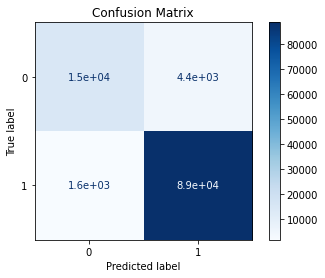

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

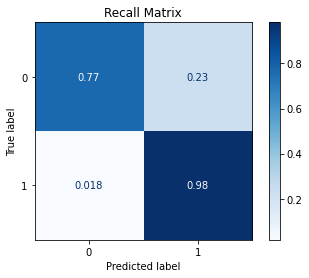

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

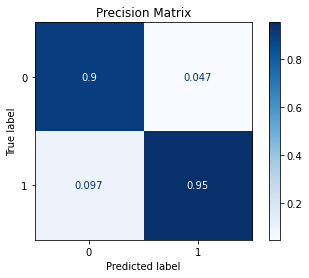

In [17]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='pred') 
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [18]:
#reporting the results in a table
from prettytable import PrettyTable

t= PrettyTable()

t.field_names =["metric/Parameter" , "result"]

t.add_row (["Model" ,"Classification"])
t.add_row (["Classifier" ,"XGB"])
t.add_row  (["Optimal_estimators" , optimal_est_tfidf])
t.add_row  (["Optimal_depth" , optimal_depth_tfidf])
t.add_row(["test accuracy" ,round(acc_XGB_tfidf,2)])
t.add_row (["Train_error" ,round(train_error_tfidf,2)])
t.add_row (["Test error" , round(test_error_tfidf,2)])

In [19]:
print(t)

+--------------------+----------------+
|  metric/Parameter  |     result     |
+--------------------+----------------+
|       Model        | Classification |
|     Classifier     |      XGB       |
| Optimal_estimators |      1000      |
|   Optimal_depth    |       11       |
|   test accuracy    |     94.56      |
|    Train_error     |      1.08      |
|     Test error     |      5.44      |
+--------------------+----------------+
